# **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Tampilkan grafik langsung di notebook
%matplotlib inline

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# **2. Menghubungkan Google Colab dengan Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3. Membaca Dataset Bersih**

In [4]:
school_path = '/content/drive/MyDrive/DataMining/Data_EDA/Dataset_bersih/cleaned_data_school_Idn.csv'
salary_path = '/content/drive/MyDrive/DataMining/Data_EDA/Dataset_bersih/cleaned_data_Indonesian_Salary.csv'

df_school = pd.read_csv(school_path)
df_salary = pd.read_csv(salary_path)

print("=== Dataset Sekolah (5 Baris Pertama) ===")
display(df_school.head())
print("\n=== Dataset Gaji (5 Baris Pertama) ===")
display(df_salary.head())

/tmp/ipython-input-1463675765.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_school = pd.read_csv(school_path)


=== Dataset Sekolah (5 Baris Pertama) ===


,Province_Id,Province_Name,City_Id,City_Name,District_Id,District,Npsn,School_Name,Stage,Status,Street_Name,Lat,Long
0,250000,Papua,251800,Kab. Tolikara,251831,Kec. Gilungbandu,60303704,SMP SATAP KAGI,SMP,N,Gilubandu,-3.415995,138.339704
1,250000,Papua,251800,Kab. Tolikara,251822,Kec. Wunin,60302267,SD YPPGI WURINERI,SD,S,Wunin,-3.479000,138.680000
2,250000,Papua,251800,Kab. Tolikara,251803,Kec. Bokondini,60302279,SMAN BOKONDINI,SMA,N,MAIRINI,-3.531731,138.658234
3,250000,Papua,251800,Kab. Tolikara,251814,Kec. Kuari,60302215,SD INPRES KUARI,SD,N,Kuari,-3.518100,138.529500
4,250000,Papua,251800,Kab. Tolikara,251802,Kec. Karubaga,60302283,SMAS YPPGI KARUBAGA,SMA,S,AMPERA,-3.449100,138.598800



=== Dataset Gaji (5 Baris Pertama) ===


,Region,Salary,Year
0,ACEH,1280000,1997
1,SUMATERA UTARA,1510000,1997
2,SUMATERA BARAT,1190000,1997
3,RIAU,1515000,1997
4,JAMBI,1195000,1997


# **4. Normalisasi Nama Kolom agar Konsisten**

In [5]:
df_school.columns = df_school.columns.str.strip().str.title().str.replace(' ', '_')
df_salary.columns = df_salary.columns.str.strip().str.title().str.replace(' ', '_')

if 'Province_Name' in df_school.columns:
    df_school.rename(columns={'Province_Name':'Provinsi'}, inplace=True)
if 'Region' in df_salary.columns:
    df_salary.rename(columns={'Region':'Provinsi'}, inplace=True)
if 'Salary' in df_salary.columns:
    df_salary.rename(columns={'Salary':'Gaji'}, inplace=True)

    # Bersihkan nama provinsi agar bisa di-merge dengan benar
df_school['Provinsi'] = df_school['Provinsi'].astype(str).str.strip().str.title()
df_salary['Provinsi'] = df_salary['Provinsi'].astype(str).str.strip().str.title()

# **5. Agregasi Data Sekolah per Provinsi**

In [6]:
if 'Npsn' in df_school.columns:
    school_counts = df_school.groupby('Provinsi').agg(Jumlah_Sekolah=('Npsn','nunique')).reset_index()
else:
    school_counts = df_school.groupby('Provinsi').agg(Jumlah_Sekolah=('School_Name','count')).reset_index()

print("\nagregasi jumlah sekolah per provinsi:")
display(school_counts.head())


agregasi jumlah sekolah per provinsi:


,Provinsi,Jumlah_Sekolah
0,Aceh,5290
1,Bali,3174
2,Bangka Belitung,1142
3,Banten,7157
4,Bengkulu,2026


# **6. Agregasi Data Gaji per Provinsi**

In [7]:
df_salary['Gaji'] = pd.to_numeric(df_salary['Gaji'], errors='coerce')
salary_agg = df_salary.groupby('Provinsi').agg(Gaji=('Gaji','mean')).reset_index()

print("\nagregasi gaji per provinsi:")
display(salary_agg.head())


agregasi gaji per provinsi:


,Provinsi,Gaji
0,Aceh,1.598199e+07
1,Bali,2.099514e+07
2,Banten,2.171500e+07
3,Bengkulu,1.159160e+07
4,Di Yogyakarta,1.542202e+07


# **7. Merge Kedua Dataset Berdasarkan Provinsi**

In [8]:
merged_df = pd.merge(school_counts, salary_agg, on='Provinsi', how='inner')

# Bersihkan nilai kosong
merged_df['Jumlah_Sekolah'] = pd.to_numeric(merged_df['Jumlah_Sekolah'], errors='coerce')
merged_df['Gaji'] = pd.to_numeric(merged_df['Gaji'], errors='coerce')
merged_df = merged_df.dropna(subset=['Jumlah_Sekolah', 'Gaji'])

print("\nJumlah data hasil merge:", len(merged_df))
display(merged_df.head())


Jumlah data hasil merge: 30


,Provinsi,Jumlah_Sekolah,Gaji
0,Aceh,5290,1.598199e+07
1,Bali,3174,2.099514e+07
2,Banten,7157,2.171500e+07
3,Bengkulu,2026,1.159160e+07
4,Gorontalo,1377,1.335027e+07


# **8. Eksplorasi Awal dan Korelasi**

In [9]:
if merged_df.empty:
    print("⚠️ Hasil merge kosong — pastikan nama provinsi sinkron di kedua dataset.")
else:
    merged_df['Log_Jumlah_Sekolah'] = np.log1p(merged_df['Jumlah_Sekolah'])
    merged_df['Log_Gaji'] = np.log1p(merged_df['Gaji'])

    corr_raw = merged_df[['Jumlah_Sekolah','Gaji']].corr().iloc[0,1]
    corr_log = merged_df[['Log_Jumlah_Sekolah','Log_Gaji']].corr().iloc[0,1]

    print(f"\nKoefisien korelasi (raw): {corr_raw:.3f}")
    print(f"Koefisien korelasi (log): {corr_log:.3f}")


Koefisien korelasi (raw): -0.297
Koefisien korelasi (log): -0.413


# **9. Visualisasi Perbandingan (Bar Chart)**

/tmp/ipython-input-1078679231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


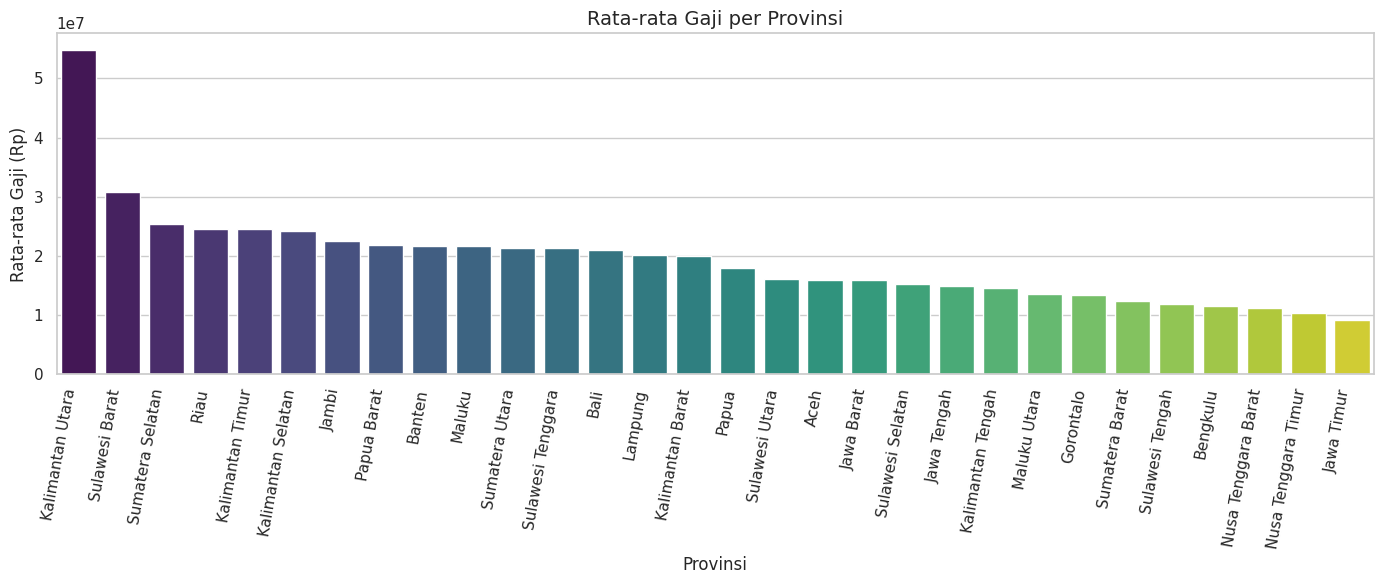

/tmp/ipython-input-1078679231.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


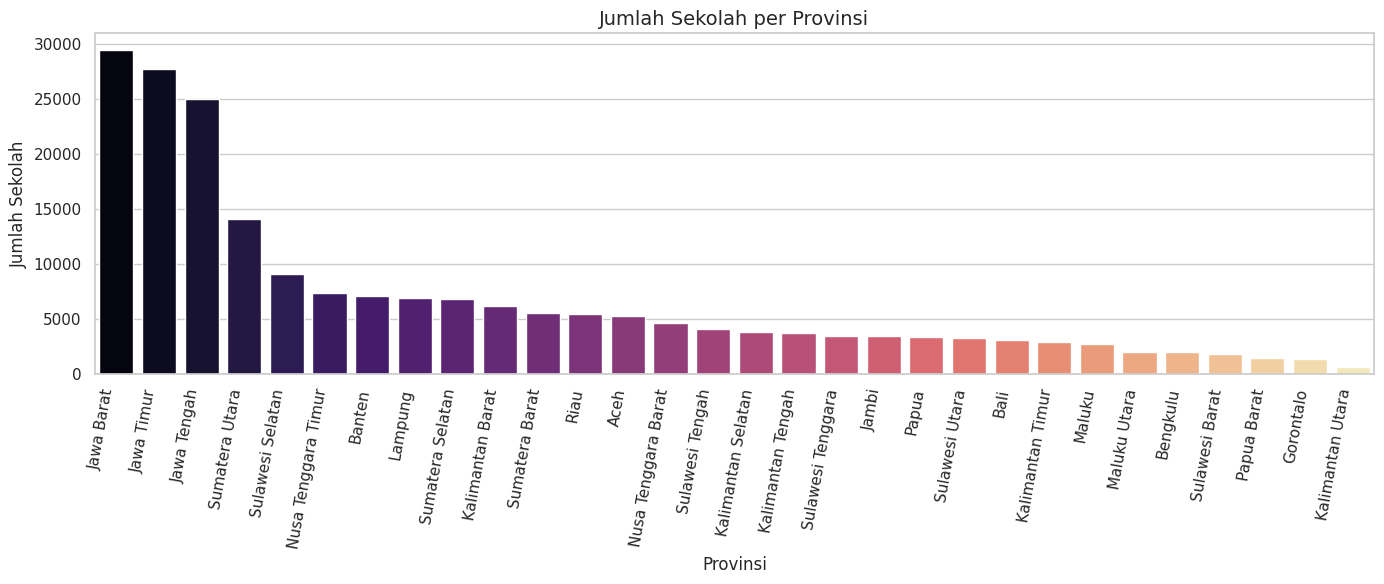

In [10]:
if not merged_df.empty:
    plt.figure(figsize=(14,6))
    sns.barplot(
        data=merged_df.sort_values('Gaji', ascending=False),
        x='Provinsi', y='Gaji', palette='viridis'
    )
    plt.title('Rata-rata Gaji per Provinsi', fontsize=14)
    plt.xlabel('Provinsi', fontsize=12)
    plt.ylabel('Rata-rata Gaji (Rp)', fontsize=12)
    plt.xticks(rotation=80, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14,6))
    sns.barplot(
        data=merged_df.sort_values('Jumlah_Sekolah', ascending=False),
        x='Provinsi', y='Jumlah_Sekolah', palette='magma'
    )
    plt.title('Jumlah Sekolah per Provinsi', fontsize=14)
    plt.xlabel('Provinsi', fontsize=12)
    plt.ylabel('Jumlah Sekolah', fontsize=12)
    plt.xticks(rotation=80, ha='right')
    plt.tight_layout()
    plt.show()

# **10. Scatter Plot Hubungan Jumlah Sekolah vs Gaji**

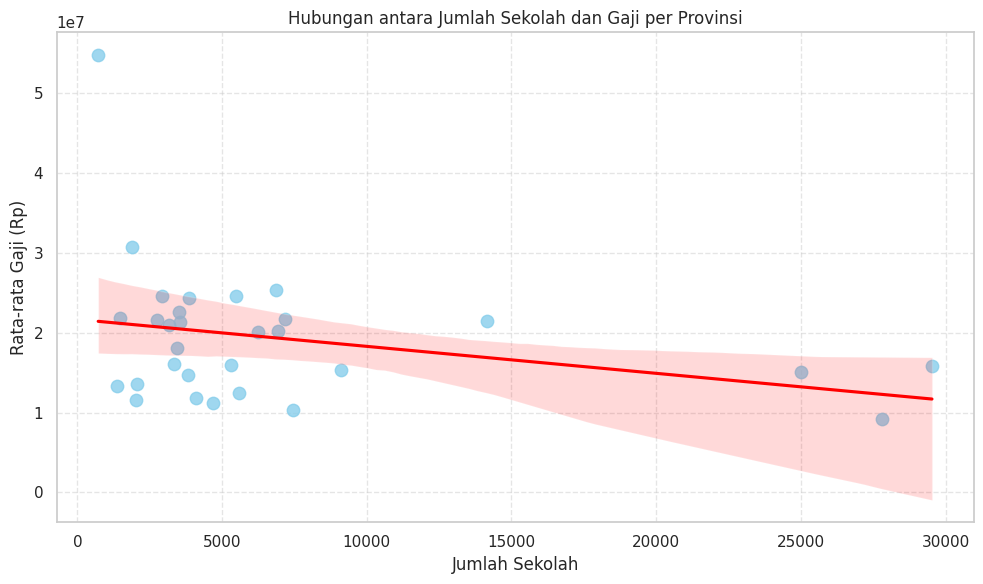

In [11]:
if not merged_df.empty:
    plt.figure(figsize=(10,6))
    sns.regplot(data=merged_df, x='Jumlah_Sekolah', y='Gaji',
                scatter_kws={'s':80, 'color':'skyblue'}, line_kws={'color':'red'})
    plt.title('Hubungan antara Jumlah Sekolah dan Gaji per Provinsi')
    plt.xlabel('Jumlah Sekolah')
    plt.ylabel('Rata-rata Gaji (Rp)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# **11. Heatmap Korelasi**

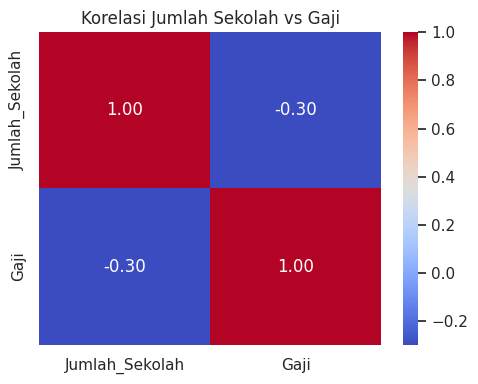

In [12]:
if not merged_df.empty:
    plt.figure(figsize=(5,4))
    sns.heatmap(merged_df[['Jumlah_Sekolah','Gaji']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Korelasi Jumlah Sekolah vs Gaji')
    plt.tight_layout()
    plt.show()